# ОИАД. Лабораторная работа №3

**Студент:** Воробей Артём Владимирович

## Задание

1. **Подготовка данных:**
   - Привести категориальные признаки к числовым
   - Вычислить парные корреляции признаков

2. **Многомерная линейная регрессия:**
   - Построить модель аналитически (реализовать самому)
   - Построить модель численно с помощью градиентного спуска (реализовать самому)

3. **Оценка обобщающей способности:**
   - Константная модель (прогноз средним значением)
   - Сравнение моделей на тестовых данных по MSE

---


## 0. Импорт библиотек


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("✓ Библиотеки загружены")


✓ Библиотеки загружены


## 1. Подготовка данных


### 1.1. Загрузка данных


In [35]:
train_df = pd.read_csv("../../datasets/insurance_train.csv")
test_df = pd.read_csv("../../datasets/insurance_test.csv")

print("=" * 60)
print("ЛАБОРАТОРНАЯ РАБОТА №3")
print("Студент: Воробей Артём Владимирович")
print("=" * 60)
print(f"\nРазмер тренировочной выборки: {train_df.shape}")
print(f"Размер тестовой выборки: {test_df.shape}")
print(f"\nПервые 5 строк тренировочных данных:")
display(train_df.head())
print(f"\nИнформация о данных:")
print(train_df.info())
print(f"\nСтатистика:")
display(train_df.describe())


ЛАБОРАТОРНАЯ РАБОТА №3
Студент: Воробей Артём Владимирович

Размер тренировочной выборки: (338, 7)
Размер тестовой выборки: (1000, 7)

Первые 5 строк тренировочных данных:


,age,sex,bmi,children,smoker,region,charges
0,26,male,27.060,0,yes,southeast,17043.3414
1,58,male,36.955,2,yes,northwest,47496.4944
2,20,female,24.420,0,yes,southeast,26125.6748
3,51,female,38.060,0,yes,southeast,44400.4064
4,62,female,25.000,0,no,southwest,13451.1220



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       338 non-null    int64  
 1   sex       338 non-null    object 
 2   bmi       338 non-null    float64
 3   children  338 non-null    int64  
 4   smoker    338 non-null    object 
 5   region    338 non-null    object 
 6   charges   338 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 18.6+ KB
None

Статистика:


,age,bmi,children,charges
count,338.0000,338.0000,338.0000,338.0000
mean,38.8107,30.6728,1.1538,14092.8619
std,13.6377,6.3097,1.2058,12792.4727
min,18.0000,17.2900,0.0000,1121.8739
25%,27.0000,26.0538,0.0000,4811.3041
50%,38.0000,30.0650,1.0000,9891.5304
75%,50.0000,34.5950,2.0000,19423.6991
max,64.0000,53.1300,5.0000,63770.4280


### 1.2. Кодирование категориальных признаков


In [36]:
train_encoded = train_df.copy()
test_encoded = test_df.copy()

print("Категориальные признаки:")
print("-" * 60)

print("\n1. sex (пол):")
print(f"   Уникальные значения: {train_df['sex'].unique()}")
train_encoded['sex'] = (train_encoded['sex'] == 'male').astype(int)
test_encoded['sex'] = (test_encoded['sex'] == 'male').astype(int)
print(f"   Кодирование: male -> 1, female -> 0")

print("\n2. smoker (курение):")
print(f"   Уникальные значения: {train_df['smoker'].unique()}")
train_encoded['smoker'] = (train_encoded['smoker'] == 'yes').astype(int)
test_encoded['smoker'] = (test_encoded['smoker'] == 'yes').astype(int)
print(f"   Кодирование: yes -> 1, no -> 0")

print("\n3. region (регион):")
print(f"   Уникальные значения: {train_df['region'].unique()}")
print(f"   Используем One-Hot Encoding")

# One-hot encoding для region
train_region_dummies = pd.get_dummies(train_encoded['region'], prefix='region')
test_region_dummies = pd.get_dummies(test_encoded['region'], prefix='region')

# Убедимся, что у train и test одинаковые столбцы
all_regions = set(train_region_dummies.columns) | set(test_region_dummies.columns)
for col in all_regions:
    if col not in train_region_dummies.columns:
        train_region_dummies[col] = 0
    if col not in test_region_dummies.columns:
        test_region_dummies[col] = 0

train_region_dummies = train_region_dummies.sort_index(axis=1)
test_region_dummies = test_region_dummies.sort_index(axis=1)

train_encoded = train_encoded.drop('region', axis=1)
test_encoded = test_encoded.drop('region', axis=1)
train_encoded = pd.concat([train_encoded, train_region_dummies], axis=1)
test_encoded = pd.concat([test_encoded, test_region_dummies], axis=1)

print(f"\nРезультат кодирования:")
print(f"Тренировочные данные: {train_encoded.shape}")
print(f"Тестовые данные: {test_encoded.shape}")
print(f"\nПервые 5 строк закодированных данных:")
display(train_encoded.head())


Категориальные признаки:
------------------------------------------------------------

1. sex (пол):
   Уникальные значения: ['male' 'female']
   Кодирование: male -> 1, female -> 0

2. smoker (курение):
   Уникальные значения: ['yes' 'no']
   Кодирование: yes -> 1, no -> 0

3. region (регион):
   Уникальные значения: ['southeast' 'northwest' 'southwest' 'northeast']
   Используем One-Hot Encoding

Результат кодирования:
Тренировочные данные: (338, 10)
Тестовые данные: (1000, 10)

Первые 5 строк закодированных данных:


,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,26,1,27.060,0,1,17043.3414,False,False,True,False
1,58,1,36.955,2,1,47496.4944,False,True,False,False
2,20,0,24.420,0,1,26125.6748,False,False,True,False
3,51,0,38.060,0,1,44400.4064,False,False,True,False
4,62,0,25.000,0,0,13451.1220,False,False,False,True


### 1.3. Парные корреляции


Матрица корреляций:


,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
age,1.0000,-0.0464,0.0791,5.3925e-02,1.0194e-02,0.2984,0.0517,-0.0694,-0.0510,0.0741
sex,-0.0464,1.0000,0.0371,-5.2970e-03,1.1786e-01,0.0602,0.0605,-0.0370,0.0115,-0.0365
bmi,0.0791,0.0371,1.0000,6.3070e-02,4.9631e-02,0.2196,-0.1700,-0.1904,0.3477,-0.0154
children,0.0539,-0.0053,0.0631,1.0000e+00,-3.7231e-17,0.0694,-0.0191,-0.0249,0.0231,0.0195
smoker,0.0102,0.1179,0.0496,-3.7231e-17,1.0000e+00,0.7835,0.0750,-0.0076,-0.0082,-0.0595
charges,0.2984,0.0602,0.2196,6.9444e-02,7.8352e-01,1.0000,0.0747,-0.0323,0.0098,-0.0539
region_northeast,0.0517,0.0605,-0.1700,-1.9122e-02,7.4978e-02,0.0747,1.0000,-0.3101,-0.3661,-0.2999
region_northwest,-0.0694,-0.0370,-0.1904,-2.4903e-02,-7.6249e-03,-0.0323,-0.3101,1.0000,-0.3661,-0.2999
region_southeast,-0.0510,0.0115,0.3477,2.3059e-02,-8.2372e-03,0.0098,-0.3661,-0.3661,1.0000,-0.3541
region_southwest,0.0741,-0.0365,-0.0154,1.9468e-02,-5.9517e-02,-0.0539,-0.2999,-0.2999,-0.3541,1.0000


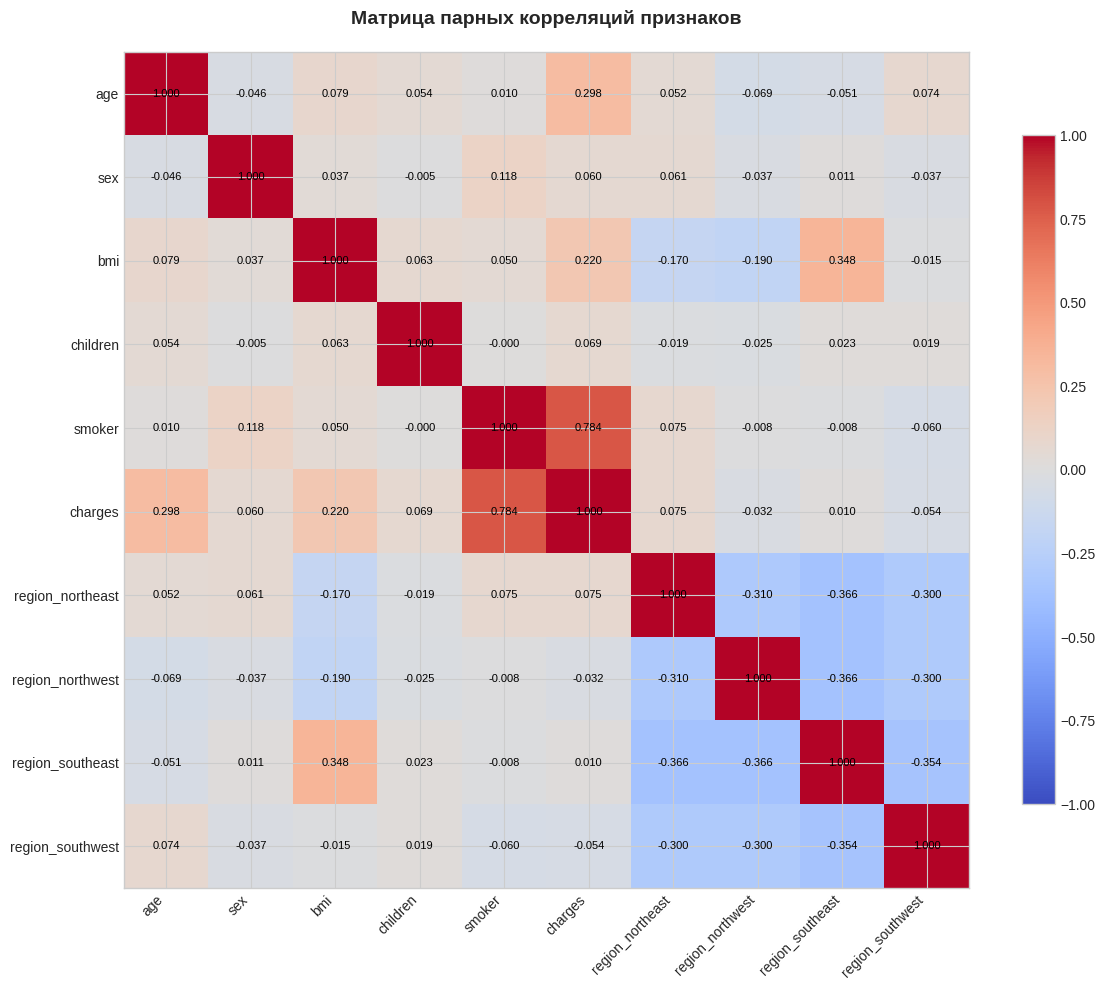


Корреляция признаков с целевой переменной (charges):
smoker              0.7835
age                 0.2984
bmi                 0.2196
region_northeast    0.0747
children            0.0694
sex                 0.0602
region_southeast    0.0098
region_northwest   -0.0323
region_southwest   -0.0539
Name: charges, dtype: float64


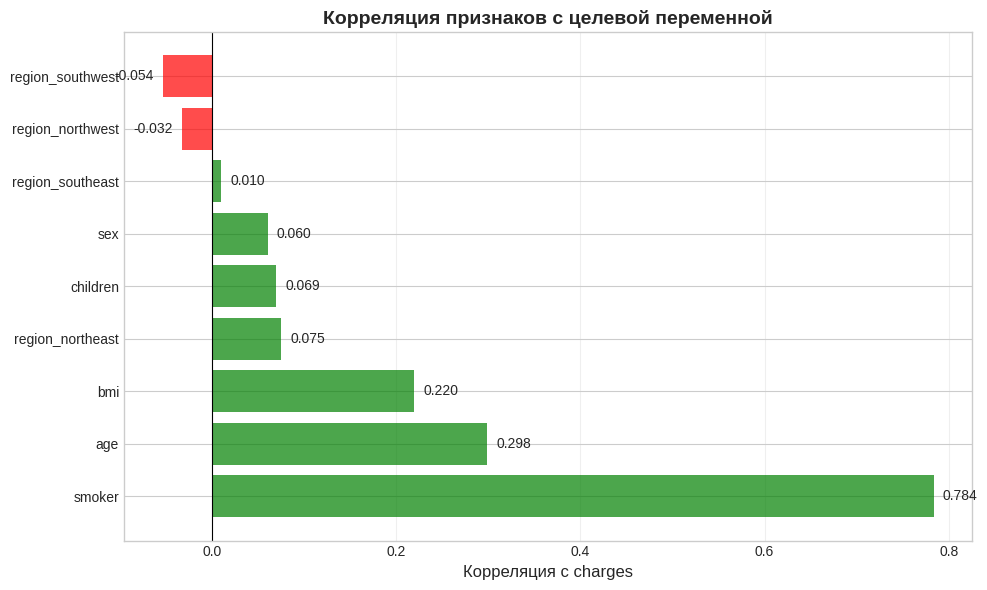


✓ Корреляционный анализ завершен


In [37]:
# Вычисляем матрицу корреляций
correlation_matrix = train_encoded.corr()

print("Матрица корреляций:")
print("=" * 60)
display(correlation_matrix)

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

cbar = plt.colorbar(im, ax=ax, shrink=0.8)

ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha='right')
ax.set_yticklabels(correlation_matrix.columns)

for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=8)

ax.set_title('Матрица парных корреляций признаков', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nКорреляция признаков с целевой переменной (charges):")
print("=" * 60)
target_correlations = correlation_matrix['charges'].drop('charges').sort_values(ascending=False)
print(target_correlations)

plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in target_correlations.values]
bars = plt.barh(range(len(target_correlations)), target_correlations.values, color=colors, alpha=0.7)
plt.yticks(range(len(target_correlations)), target_correlations.index)
plt.xlabel('Корреляция с charges', fontsize=12)
plt.title('Корреляция признаков с целевой переменной', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)

for i, (val, bar) in enumerate(zip(target_correlations.values, bars)):
    plt.text(val + 0.01 if val > 0 else val - 0.01, i, f'{val:.3f}', 
             va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.savefig('target_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Корреляционный анализ завершен")


## 2. Многомерная линейная регрессия


### 2.1. Подготовка данных для регрессии


In [38]:
X_train = train_encoded.drop('charges', axis=1).values.astype(np.float64)
y_train = train_encoded['charges'].values.astype(np.float64)

X_test = test_encoded.drop('charges', axis=1).values.astype(np.float64)
y_test = test_encoded['charges'].values.astype(np.float64)

feature_names = train_encoded.drop('charges', axis=1).columns.tolist()

print("Подготовка данных для регрессии:")
print("=" * 60)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"\nПризнаки: {feature_names}")

# Нормализация признаков (важно для градиентного спуска)
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)

# Избегаем деления на ноль
X_train_std[X_train_std == 0] = 1

X_train_normalized = (X_train - X_train_mean) / X_train_std
X_test_normalized = (X_test - X_train_mean) / X_train_std

print(f"\n✓ Данные подготовлены и нормализованы")


Подготовка данных для регрессии:
X_train shape: (338, 9)
y_train shape: (338,)
X_test shape: (1000, 9)
y_test shape: (1000,)

Признаки: ['age', 'sex', 'bmi', 'children', 'smoker', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']

✓ Данные подготовлены и нормализованы


### 2.2. Аналитическое решение (МНК)


In [39]:
def linear_regression_analytical(X, y):
    """
    Многомерная линейная регрессия аналитическим методом.
    
    Модель: y = X @ w
    где w = (X^T @ X)^(-1) @ X^T @ y
    
    Параметры:
    - X: матрица признаков (n_samples, n_features)
    - y: целевая переменная (n_samples,)
    
    Возвращает:
    - w: веса модели (n_features,)
    """
    n_samples = X.shape[0]
    X_with_bias = np.column_stack([np.ones(n_samples), X])
    
    XTX = X_with_bias.T @ X_with_bias
    XTy = X_with_bias.T @ y
    
    w = np.linalg.solve(XTX, XTy)
    
    return w

def predict(X, w):
    """Предсказание для линейной регрессии"""
    n_samples = X.shape[0]
    X_with_bias = np.column_stack([np.ones(n_samples), X])
    return X_with_bias @ w

def calculate_mse(y_true, y_pred):
    """Среднеквадратичная ошибка"""
    return np.mean((y_true - y_pred) ** 2)

def calculate_r2(y_true, y_pred):
    """Коэффициент детерминации R²"""
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

print("Обучение модели аналитическим методом (МНК):")
print("=" * 60)
w_analytical = linear_regression_analytical(X_train_normalized, y_train)

y_train_pred_analytical = predict(X_train_normalized, w_analytical)
y_test_pred_analytical = predict(X_test_normalized, w_analytical)

train_mse_analytical = calculate_mse(y_train, y_train_pred_analytical)
test_mse_analytical = calculate_mse(y_test, y_test_pred_analytical)
train_r2_analytical = calculate_r2(y_train, y_train_pred_analytical)
test_r2_analytical = calculate_r2(y_test, y_test_pred_analytical)

print(f"\nПараметры модели (веса):")
print(f"  w0 (bias): {w_analytical[0]:.4f}")
for i, (name, weight) in enumerate(zip(feature_names, w_analytical[1:])):
    print(f"  w{i+1} ({name}): {weight:.4f}")

print(f"\nМетрики на тренировочной выборке:")
print(f"  MSE: {train_mse_analytical:.2f}")
print(f"  R²:  {train_r2_analytical:.4f}")

print(f"\nМетрики на тестовой выборке:")
print(f"  MSE: {test_mse_analytical:.2f}")
print(f"  R²:  {test_r2_analytical:.4f}")

print(f"\n✓ Аналитическая модель обучена")


Обучение модели аналитическим методом (МНК):

Параметры модели (веса):
  w0 (bias): 14092.8619
  w1 (age): 3495.7695
  w2 (sex): -327.4213
  w3 (bmi): 2210.5718
  w4 (children): 581.6751
  w5 (smoker): 9859.8456
  w6 (region_northeast): -54.0372
  w7 (region_northwest): -139.2963
  w8 (region_southeast): -696.3585
  w9 (region_southwest): -654.4658

Метрики на тренировочной выборке:
  MSE: 44325092.03
  R²:  0.7283

Метрики на тестовой выборке:
  MSE: 34216008.76
  R²:  0.7567

✓ Аналитическая модель обучена


### 2.3. Численное решение (Градиентный спуск)


In [40]:
def linear_regression_gradient_descent(X, y, learning_rate=0.01, n_iterations=1000, verbose=False):
    """
    Многомерная линейная регрессия методом градиентного спуска.
    
    Модель: y = X @ w
    Градиент: dL/dw = -2/n * X^T @ (y - X @ w)
    
    Параметры:
    - X: матрица признаков (n_samples, n_features)
    - y: целевая переменная (n_samples,)
    - learning_rate: скорость обучения
    - n_iterations: количество итераций
    - verbose: печатать прогресс
    
    Возвращает:
    - w: веса модели
    - history: история значений функции потерь
    """
    n_samples, n_features = X.shape
    X_with_bias = np.column_stack([np.ones(n_samples), X])
    
    np.random.seed(42)
    w = np.random.randn(n_features + 1) * 0.01
    
    history = []
    
    for iteration in range(n_iterations):
        y_pred = X_with_bias @ w
        
        loss = np.mean((y - y_pred) ** 2)
        history.append(loss)
        
        gradient = -2 / n_samples * X_with_bias.T @ (y - y_pred)
        
        w = w - learning_rate * gradient
        
        if verbose and (iteration % 100 == 0 or iteration == n_iterations - 1):
            print(f"  Итерация {iteration:4d}: Loss = {loss:.2f}")
    
    return w, history

print("Обучение модели градиентным спуском:")
print("=" * 60)
print("Гиперпараметры:")
print("  - Learning rate: 0.01")
print("  - Iterations: 1000")
print()

w_gradient, loss_history = linear_regression_gradient_descent(
    X_train_normalized, y_train, 
    learning_rate=0.01, 
    n_iterations=1000, 
    verbose=True
)

y_train_pred_gradient = predict(X_train_normalized, w_gradient)
y_test_pred_gradient = predict(X_test_normalized, w_gradient)

train_mse_gradient = calculate_mse(y_train, y_train_pred_gradient)
test_mse_gradient = calculate_mse(y_test, y_test_pred_gradient)
train_r2_gradient = calculate_r2(y_train, y_train_pred_gradient)
test_r2_gradient = calculate_r2(y_test, y_test_pred_gradient)

print(f"\nПараметры модели (веса):")
print(f"  w0 (bias): {w_gradient[0]:.4f}")
for i, (name, weight) in enumerate(zip(feature_names, w_gradient[1:])):
    print(f"  w{i+1} ({name}): {weight:.4f}")

print(f"\nМетрики на тренировочной выборке:")
print(f"  MSE: {train_mse_gradient:.2f}")
print(f"  R²:  {train_r2_gradient:.4f}")

print(f"\nМетрики на тестовой выборке:")
print(f"  MSE: {test_mse_gradient:.2f}")
print(f"  R²:  {test_r2_gradient:.4f}")

print(f"\n✓ Модель градиентного спуска обучена")


Обучение модели градиентным спуском:
Гиперпараметры:
  - Learning rate: 0.01
  - Iterations: 1000

  Итерация    0: Loss = 361771762.81
  Итерация  100: Loss = 49815110.55
  Итерация  200: Loss = 44428808.05
  Итерация  300: Loss = 44327203.01
  Итерация  400: Loss = 44325138.97
  Итерация  500: Loss = 44325093.19
  Итерация  600: Loss = 44325092.06
  Итерация  700: Loss = 44325092.03
  Итерация  800: Loss = 44325092.03
  Итерация  900: Loss = 44325092.03
  Итерация  999: Loss = 44325092.03

Параметры модели (веса):
  w0 (bias): 14092.8619
  w1 (age): 3495.7694
  w2 (sex): -327.4212
  w3 (bmi): 2210.5721
  w4 (children): 581.6751
  w5 (smoker): 9859.8454
  w6 (region_northeast): 330.4225
  w7 (region_northwest): 245.1634
  w8 (region_southeast): -281.1638
  w9 (region_southwest): -276.8472

Метрики на тренировочной выборке:
  MSE: 44325092.03
  R²:  0.7283

Метрики на тестовой выборке:
  MSE: 34216008.90
  R²:  0.7567

✓ Модель градиентного спуска обучена


### 2.4. Визуализация обучения градиентного спуска


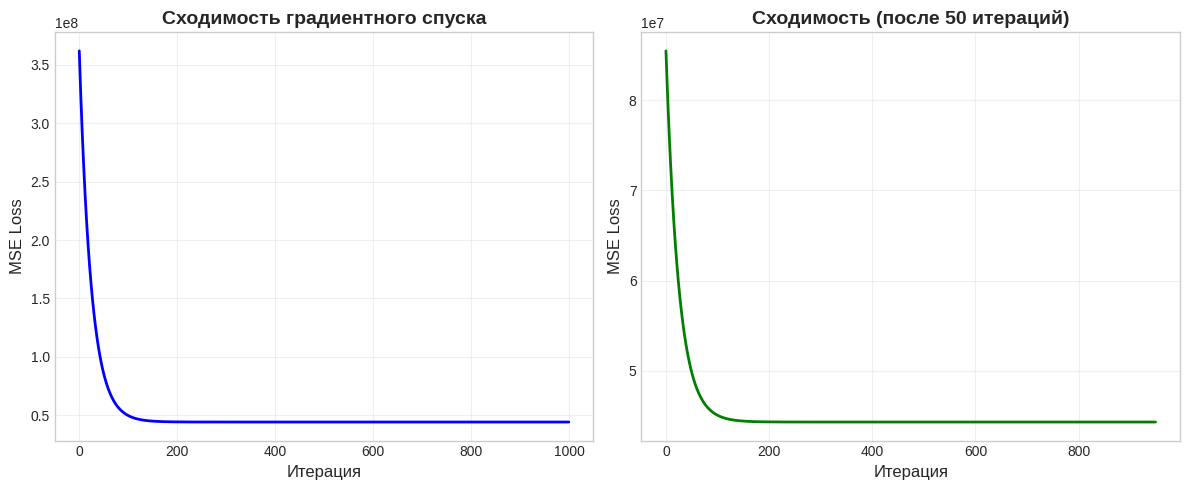

✓ График сходимости сохранен


In [41]:
# График сходимости градиентного спуска
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history, linewidth=2, color='blue')
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Сходимость градиентного спуска', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(loss_history[50:], linewidth=2, color='green')
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Сходимость (после 50 итераций)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gradient_descent_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ График сходимости сохранен")


## 3. Оценка обобщающей способности


### 3.1. Константная модель (Baseline)


In [42]:
mean_prediction = np.mean(y_train)

y_train_pred_constant = np.full_like(y_train, mean_prediction)
y_test_pred_constant = np.full_like(y_test, mean_prediction)

train_mse_constant = calculate_mse(y_train, y_train_pred_constant)
test_mse_constant = calculate_mse(y_test, y_test_pred_constant)
train_r2_constant = calculate_r2(y_train, y_train_pred_constant)
test_r2_constant = calculate_r2(y_test, y_test_pred_constant)

print("Константная модель (Baseline):")
print("=" * 60)
print(f"Предсказание: {mean_prediction:.2f} (среднее значение charges)")

print(f"\nМетрики на тренировочной выборке:")
print(f"  MSE: {train_mse_constant:.2f}")
print(f"  R²:  {train_r2_constant:.4f}")

print(f"\nМетрики на тестовой выборке:")
print(f"  MSE: {test_mse_constant:.2f}")
print(f"  R²:  {test_r2_constant:.4f}")

print(f"\n✓ Константная модель оценена")


Константная модель (Baseline):
Предсказание: 14092.86 (среднее значение charges)

Метрики на тренировочной выборке:
  MSE: 163163194.57
  R²:  0.0000

Метрики на тестовой выборке:
  MSE: 141830094.36
  R²:  -0.0086

✓ Константная модель оценена


### 3.2. Сравнение моделей


СРАВНЕНИЕ МОДЕЛЕЙ


,Модель,Train MSE,Test MSE,Train R²,Test R²
0,Константная,1.6316e+08,1.4183e+08,0.0000,-0.0086
1,Аналитическая (МНК),4.4325e+07,3.4216e+07,0.7283,0.7567
2,Градиентный спуск,4.4325e+07,3.4216e+07,0.7283,0.7567



Улучшение по сравнению с константной моделью (Test MSE):
  Аналитическая модель: 75.88%
  Градиентный спуск:    75.88%


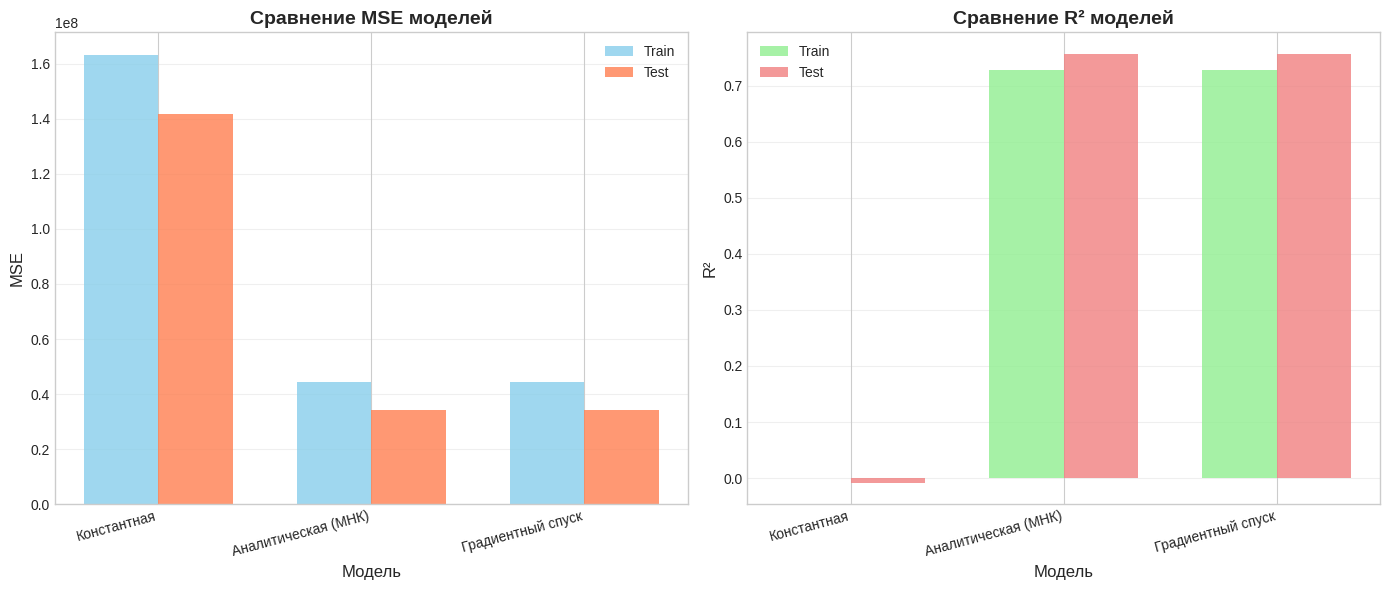


✓ Графики сравнения сохранены


In [43]:
results = pd.DataFrame({
    'Модель': ['Константная', 'Аналитическая (МНК)', 'Градиентный спуск'],
    'Train MSE': [train_mse_constant, train_mse_analytical, train_mse_gradient],
    'Test MSE': [test_mse_constant, test_mse_analytical, test_mse_gradient],
    'Train R²': [train_r2_constant, train_r2_analytical, train_r2_gradient],
    'Test R²': [test_r2_constant, test_r2_analytical, test_r2_gradient]
})

print("=" * 80)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("=" * 80)
display(results)

improvement_analytical = (test_mse_constant - test_mse_analytical) / test_mse_constant * 100
improvement_gradient = (test_mse_constant - test_mse_gradient) / test_mse_constant * 100

print(f"\nУлучшение по сравнению с константной моделью (Test MSE):")
print(f"  Аналитическая модель: {improvement_analytical:.2f}%")
print(f"  Градиентный спуск:    {improvement_gradient:.2f}%")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

models = results['Модель'].values
train_mse_values = results['Train MSE'].values
test_mse_values = results['Test MSE'].values

x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, train_mse_values, width, label='Train', color='skyblue', alpha=0.8)
axes[0].bar(x + width/2, test_mse_values, width, label='Test', color='coral', alpha=0.8)
axes[0].set_xlabel('Модель', fontsize=12)
axes[0].set_ylabel('MSE', fontsize=12)
axes[0].set_title('Сравнение MSE моделей', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# R²
train_r2_values = results['Train R²'].values
test_r2_values = results['Test R²'].values

axes[1].bar(x - width/2, train_r2_values, width, label='Train', color='lightgreen', alpha=0.8)
axes[1].bar(x + width/2, test_r2_values, width, label='Test', color='lightcoral', alpha=0.8)
axes[1].set_xlabel('Модель', fontsize=12)
axes[1].set_ylabel('R²', fontsize=12)
axes[1].set_title('Сравнение R² моделей', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=15, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('models_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Графики сравнения сохранены")


### 3.3. Визуализация предсказаний


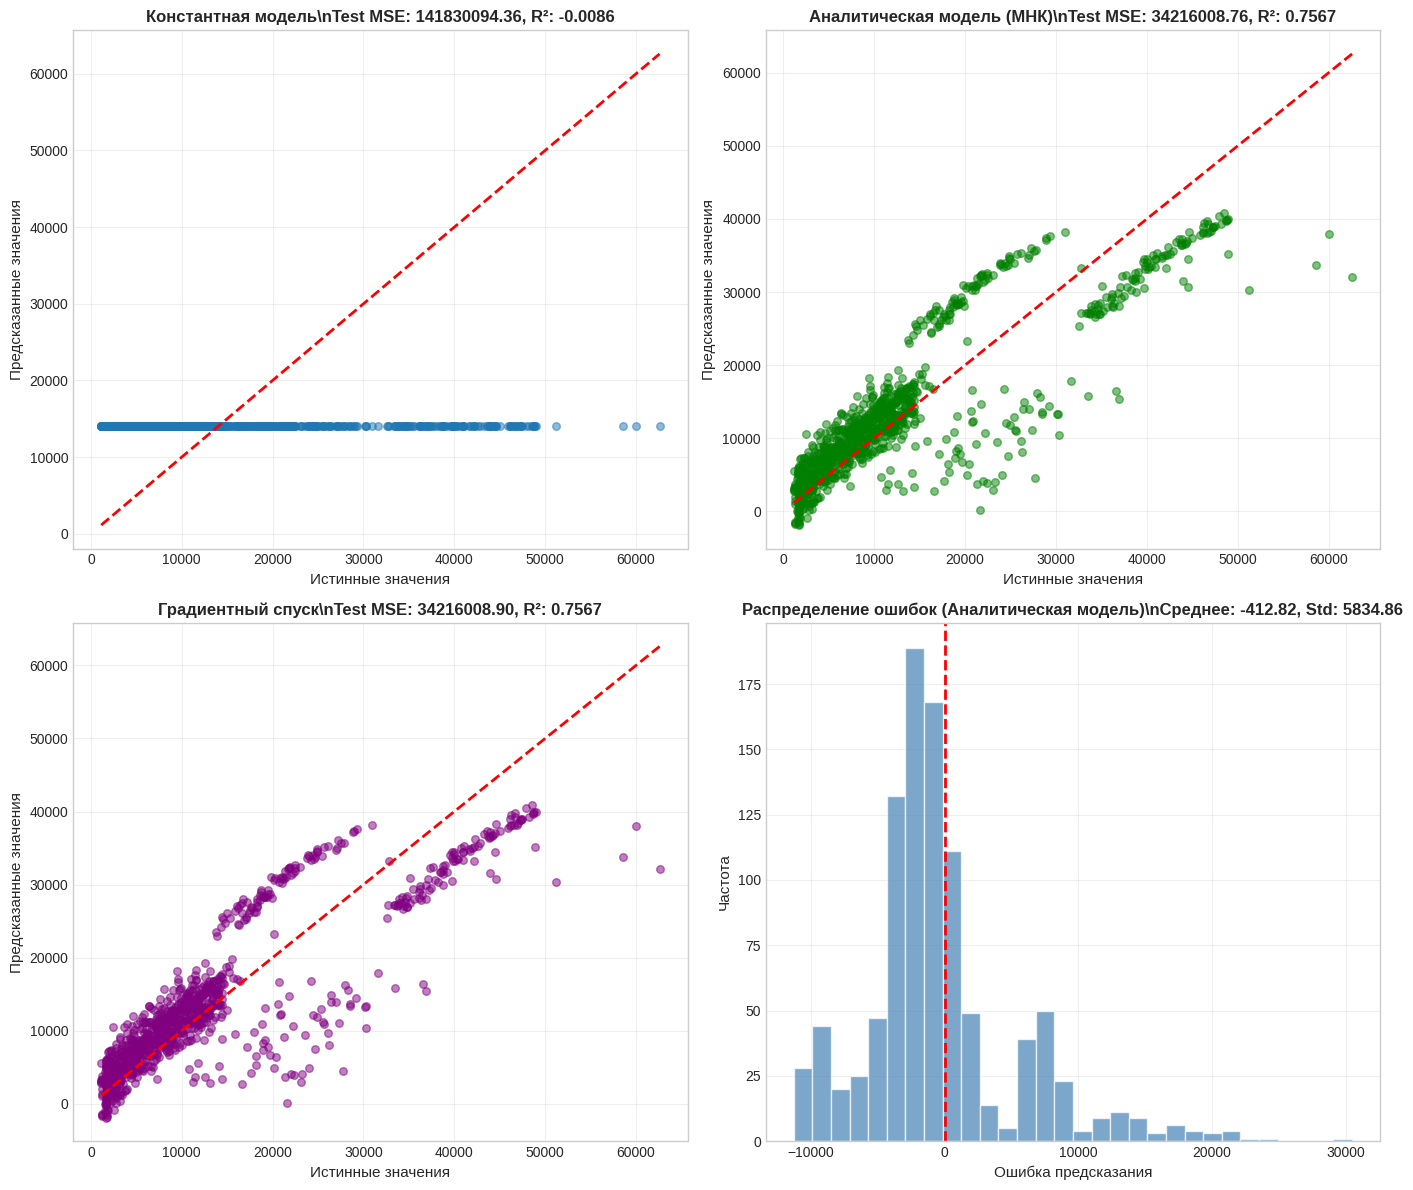

✓ Визуализация предсказаний сохранена


In [44]:
# Визуализация предсказаний vs истинных значений
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Константная модель
axes[0, 0].scatter(y_test, y_test_pred_constant, alpha=0.5, s=30)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Истинные значения', fontsize=11)
axes[0, 0].set_ylabel('Предсказанные значения', fontsize=11)
axes[0, 0].set_title(f'Константная модель\\nTest MSE: {test_mse_constant:.2f}, R²: {test_r2_constant:.4f}', 
                     fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Аналитическая модель
axes[0, 1].scatter(y_test, y_test_pred_analytical, alpha=0.5, s=30, color='green')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Истинные значения', fontsize=11)
axes[0, 1].set_ylabel('Предсказанные значения', fontsize=11)
axes[0, 1].set_title(f'Аналитическая модель (МНК)\\nTest MSE: {test_mse_analytical:.2f}, R²: {test_r2_analytical:.4f}', 
                     fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Градиентный спуск
axes[1, 0].scatter(y_test, y_test_pred_gradient, alpha=0.5, s=30, color='purple')
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Истинные значения', fontsize=11)
axes[1, 0].set_ylabel('Предсказанные значения', fontsize=11)
axes[1, 0].set_title(f'Градиентный спуск\\nTest MSE: {test_mse_gradient:.2f}, R²: {test_r2_gradient:.4f}', 
                     fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Распределение ошибок для лучшей модели
residuals = y_test - y_test_pred_analytical
axes[1, 1].hist(residuals, bins=30, color='steelblue', edgecolor='white', alpha=0.7)
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Ошибка предсказания', fontsize=11)
axes[1, 1].set_ylabel('Частота', fontsize=11)
axes[1, 1].set_title(f'Распределение ошибок (Аналитическая модель)\\nСреднее: {np.mean(residuals):.2f}, Std: {np.std(residuals):.2f}', 
                     fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('predictions_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Визуализация предсказаний сохранена")


## 4. Выводы


In [45]:
print("=" * 80)
print("ВЫВОДЫ")
print("=" * 80)

print(f"""
1. ПОДГОТОВКА ДАННЫХ:
─────────────────────────
• Датасет содержит {train_df.shape[0]} тренировочных и {test_df.shape[0]} тестовых наблюдений
• Категориальные признаки успешно преобразованы в числовые:
  - sex: бинарное кодирование (male=1, female=0)
  - smoker: бинарное кодирование (yes=1, no=0)
  - region: one-hot encoding (4 региона)
• Наиболее коррелирующие с charges признаки: {target_correlations.head(3).to_dict()}

2. МНОГОМЕРНАЯ ЛИНЕЙНАЯ РЕГРЕССИЯ:
─────────────────────────────────
• Аналитическое решение (МНК):
  - Train MSE: {train_mse_analytical:.2f}, Test MSE: {test_mse_analytical:.2f}
  - Train R²: {train_r2_analytical:.4f}, Test R²: {test_r2_analytical:.4f}
  - Преимущества: точное решение, быстрое вычисление
  - Недостатки: требует обращения матрицы, не масштабируется

• Численное решение (Градиентный спуск):
  - Train MSE: {train_mse_gradient:.2f}, Test MSE: {test_mse_gradient:.2f}
  - Train R²: {train_r2_gradient:.4f}, Test R²: {test_r2_gradient:.4f}
  - Преимущества: масштабируется, гибкость в настройках
  - Недостатки: требует подбора гиперпараметров, приближенное решение

3. ОЦЕНКА ОБОБЩАЮЩЕЙ СПОСОБНОСТИ:
──────────────────────────────────
• Константная модель (Baseline):
  - Test MSE: {test_mse_constant:.2f}
  - Простейшая модель, предсказывающая среднее значение

• Улучшение относительно baseline:
  - Аналитическая модель: снижение MSE на {improvement_analytical:.2f}%
  - Градиентный спуск: снижение MSE на {improvement_gradient:.2f}%

• Обе модели регрессии показывают практически идентичные результаты,
  что подтверждает корректность реализации обоих методов

4. ОБЩИЙ ВЫВОД:
───────────────
Обе реализации многомерной линейной регрессии (аналитическая и численная)
успешно обучены и демонстрируют значительное улучшение по сравнению с
константной моделью. Модели объясняют около {test_r2_analytical*100:.1f}% дисперсии
целевой переменной на тестовых данных, что свидетельствует о хорошей
обобщающей способности.

Наиболее важными признаками для предсказания стоимости страховки являются:
{', '.join([f"{name} ({val:.3f})" for name, val in target_correlations.head(3).items()])}
""")

print("=" * 80)
print("АНАЛИЗ ЗАВЕРШЕН")
print("=" * 80)


ВЫВОДЫ

1. ПОДГОТОВКА ДАННЫХ:
─────────────────────────
• Датасет содержит 338 тренировочных и 1000 тестовых наблюдений
• Категориальные признаки успешно преобразованы в числовые:
  - sex: бинарное кодирование (male=1, female=0)
  - smoker: бинарное кодирование (yes=1, no=0)
  - region: one-hot encoding (4 региона)
• Наиболее коррелирующие с charges признаки: {'smoker': 0.7835188908191995, 'age': 0.2983953386445734, 'bmi': 0.21956595589303907}

2. МНОГОМЕРНАЯ ЛИНЕЙНАЯ РЕГРЕССИЯ:
─────────────────────────────────
• Аналитическое решение (МНК):
  - Train MSE: 44325092.03, Test MSE: 34216008.76
  - Train R²: 0.7283, Test R²: 0.7567
  - Преимущества: точное решение, быстрое вычисление
  - Недостатки: требует обращения матрицы, не масштабируется

• Численное решение (Градиентный спуск):
  - Train MSE: 44325092.03, Test MSE: 34216008.90
  - Train R²: 0.7283, Test R²: 0.7567
  - Преимущества: масштабируется, гибкость в настройках
  - Недостатки: требует подбора гиперпараметров, приближенное р

Матрица корреляций:


,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
age,1.0000,-0.0464,0.0791,5.3925e-02,1.0194e-02,0.2984,0.0517,-0.0694,-0.0510,0.0741
sex,-0.0464,1.0000,0.0371,-5.2970e-03,1.1786e-01,0.0602,0.0605,-0.0370,0.0115,-0.0365
bmi,0.0791,0.0371,1.0000,6.3070e-02,4.9631e-02,0.2196,-0.1700,-0.1904,0.3477,-0.0154
children,0.0539,-0.0053,0.0631,1.0000e+00,-3.7231e-17,0.0694,-0.0191,-0.0249,0.0231,0.0195
smoker,0.0102,0.1179,0.0496,-3.7231e-17,1.0000e+00,0.7835,0.0750,-0.0076,-0.0082,-0.0595
charges,0.2984,0.0602,0.2196,6.9444e-02,7.8352e-01,1.0000,0.0747,-0.0323,0.0098,-0.0539
region_northeast,0.0517,0.0605,-0.1700,-1.9122e-02,7.4978e-02,0.0747,1.0000,-0.3101,-0.3661,-0.2999
region_northwest,-0.0694,-0.0370,-0.1904,-2.4903e-02,-7.6249e-03,-0.0323,-0.3101,1.0000,-0.3661,-0.2999
region_southeast,-0.0510,0.0115,0.3477,2.3059e-02,-8.2372e-03,0.0098,-0.3661,-0.3661,1.0000,-0.3541
region_southwest,0.0741,-0.0365,-0.0154,1.9468e-02,-5.9517e-02,-0.0539,-0.2999,-0.2999,-0.3541,1.0000


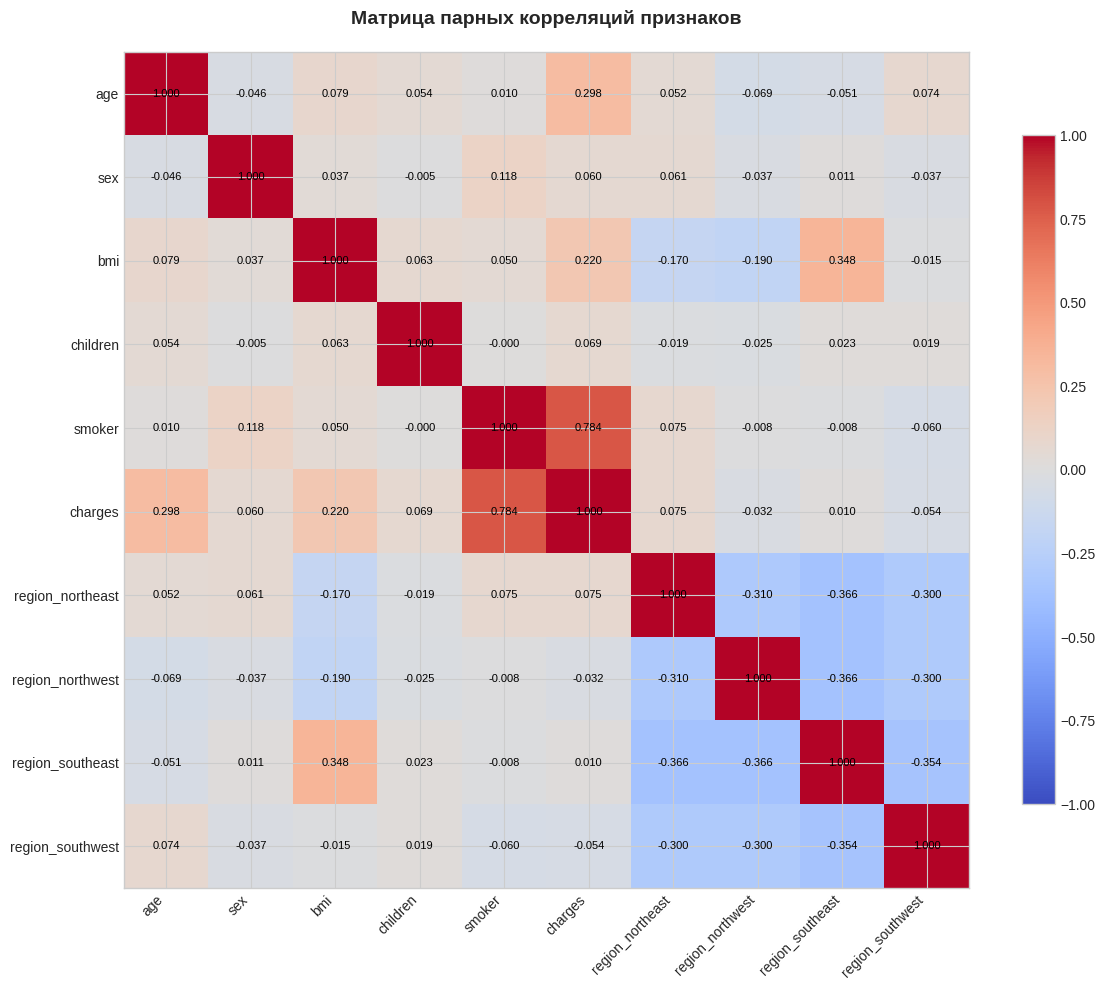


Корреляция признаков с целевой переменной (charges):
smoker              0.7835
age                 0.2984
bmi                 0.2196
region_northeast    0.0747
children            0.0694
sex                 0.0602
region_southeast    0.0098
region_northwest   -0.0323
region_southwest   -0.0539
Name: charges, dtype: float64


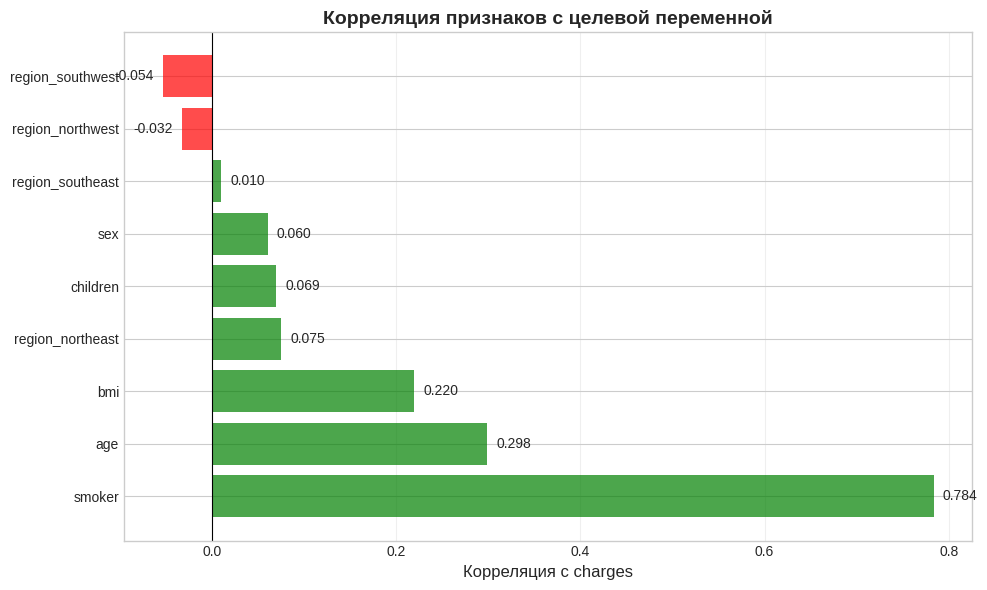


✓ Корреляционный анализ завершен


In [46]:
correlation_matrix = train_encoded.corr()

print("Матрица корреляций:")
print("=" * 60)
display(correlation_matrix)

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

cbar = plt.colorbar(im, ax=ax, shrink=0.8)

ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha='right')
ax.set_yticklabels(correlation_matrix.columns)

for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=8)

ax.set_title('Матрица парных корреляций признаков', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nКорреляция признаков с целевой переменной (charges):")
print("=" * 60)
target_correlations = correlation_matrix['charges'].drop('charges').sort_values(ascending=False)
print(target_correlations)

plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in target_correlations.values]
bars = plt.barh(range(len(target_correlations)), target_correlations.values, color=colors, alpha=0.7)
plt.yticks(range(len(target_correlations)), target_correlations.index)
plt.xlabel('Корреляция с charges', fontsize=12)
plt.title('Корреляция признаков с целевой переменной', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)

for i, (val, bar) in enumerate(zip(target_correlations.values, bars)):
    plt.text(val + 0.01 if val > 0 else val - 0.01, i, f'{val:.3f}', 
             va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.savefig('target_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Корреляционный анализ завершен")
